# Pix2Pix - Image-to-Image Translation in Raw PyTorch

Ce notebook implémente l'architecture Pix2Pix (Isola et al., 2017) pour la traduction d'images (ex: croquis -> photo, jour -> nuit) en utilisant **PyTorch pur**.

## Objectifs Techniques
- **Architecture**: Generator U-Net + Discriminator PatchGAN.
- **Loss**: Adversarial Loss (BCE) + L1 Loss (Reconstruction).
- **Dataset**: Gestion d'images paires concaténées horizontalement.
- **Training**: Boucle d'entraînement personnalisée avec mises à jour alternées.
- **Améliorations**: Validation, Early Stopping, Sauvegarde du meilleur modèle, Plotting, Logging.

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from datetime import datetime

## 1. Configuration & Hyperparamètres

In [16]:
class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LEARNING_RATE = 2e-4
    BATCH_SIZE = 1  # Pix2Pix utilise souvent batch_size=1 pour de meilleurs resultats qualitatifs (InstanceNorm, etc.)
    NUM_WORKERS = 2
    IMAGE_SIZE = 256
    CHANNELS_IMG = 3
    L1_LAMBDA = 100  # Poids de la perte L1 par rapport a la perte GAN
    NUM_EPOCHS = 200
    LOAD_MODEL = False
    SAVE_MODEL = True
    CHECKPOINT_DISC = "disc.pth.tar"
    CHECKPOINT_GEN = "gen.pth.tar"
    CHECKPOINT_GEN_BEST = "gen_best.pth.tar"
    
    TRAIN_DIR = "pix2pix-dataset/versions/2/maps/maps/train"
    VAL_DIR = "pix2pix-dataset/versions/2/maps/maps/val"
    
    # Limite pour le debug/test rapide (None = tout le dataset)
    TRAIN_SIZE_LIMIT = None 
    PATIENCE = 10
    LOG_FILE = "training_logs.csv"
    
print(f"Device used: {Config.DEVICE}")

Device used: cuda


## 2. Pipeline de Données (Paired Dataset)

Les datasets Pix2Pix consistent souvent en des images concaténées (Input à gauche, Target à droite, ou inversement).

In [17]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        if os.path.exists(root_dir):
            self.list_files = os.listdir(root_dir)
        else:
            print(f"Attention: Le dossier {root_dir} n'existe pas. Assurez-vous de charger vos donnees.")
            self.list_files = []

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))

        w = image.shape[1]
        cutoff = w // 2
    
        # Inversion ici :
        # Si la photo est à gauche et le label à droite dans votre fichier image :
        target_image = image[:, :cutoff, :]  # La photo devient la CIBLE (Target)
        input_image = image[:, cutoff:, :]   # Le label/bleu-orange devient l'ENTREE (Input)
        
        # Augmentations (Jittering)
        # Redimensionner l'image a une taille un peu plus grande, puis crop aleatoire
        # Convertir en PIL pour utiliser les transforms torchvision facilement
        
        # Setup PIL
        input_image = Image.fromarray(input_image)
        target_image = Image.fromarray(target_image)
        
        # Resize sans crop
        resize = transforms.Resize((286, 286))
        input_image = resize(input_image)
        target_image = resize(target_image)
        
        # Random Crop (meme parametres)
        i, j, h, w = transforms.RandomCrop.get_params(
            input_image, output_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE)
        )
        input_image = transforms.functional.crop(input_image, i, j, h, w)
        target_image = transforms.functional.crop(target_image, i, j, h, w)
        
        # Random Flip (meme parametres)
        if torch.rand(1) > 0.5:
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)
            
        # ToTensor & Normalize
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        
        input_image = base_transform(input_image)
        target_image = base_transform(target_image)

        return input_image, target_image

## 3. Architecture du Discriminateur (PatchGAN)

Le discriminateur PatchGAN divise l'image en patchs NxN et classifie chaque patch comme 'real' ou 'fake'. 
Cela force le générateur à produire des détails haute fréquence (textures) réalistes, car le discriminateur se concentre sur la structure locale.

In [18]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        # Entree: Concatenation de x (input) et y (target/fake) -> in_channels * 2
        # Couche initiale sans BatchNorm
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature

        # Couche finale pour obtenir une map 1 canal (patch predictions)
        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)  # FIX: Passer par la couche initiale d'abord !
        return self.model(x)

## 4. Architecture du Générateur (U-Net)

U-Net avec connexions de saut (skip connections) pour préserver les informations spatiales.
- **Encoder**: Downsampling (Conv2d)
- **Decoder**: Upsampling (ConvTranspose2d) + Concatenation

In [19]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.block(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        # Encoder
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1, padding_mode="reflect"),
            nn.ReLU(),
        )

        # Decoder
        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        
        # Final output layer
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(), # Sortie normalisee [-1, 1]
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        
        # Skip connections (concatenation)
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        
        return self.final_up(torch.cat([u7, d1], 1))

## 5. Fonctions Utilitaires & Visualisation

In [20]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
    if not os.path.exists(folder):
        os.makedirs(folder)
        
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        # Denormalisation pour affichage (x * 0.5 + 0.5)
        y_fake = y_fake * 0.5 + 0.5
        x = x * 0.5 + 0.5
        y = y * 0.5 + 0.5
        save_image(y_fake, folder + f"/gen_{epoch}.png")
        save_image(x, folder + f"/input_{epoch}.png")
        save_image(y, folder + f"/label_{epoch}.png")
        
    gen.train()

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 6. Fonctions de Training, Validation, Logging, Plotting

In [21]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)
    d_losses = []
    g_losses = []

    for idx, (x, y) in enumerate(loop):
        x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)

        # --- Train Discriminator ---
        with torch.amp.autocast('cuda'):
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # --- Train Generator ---
        with torch.amp.autocast('cuda'):
            D_fake = disc(x, y_fake)
            # On veut tromper le discriminateur -> on vise 1 pour les fake
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            
            # L1 Loss pour la similarite pixel-wise
            L1 = l1_loss(y_fake, y) * Config.L1_LAMBDA
            
            G_loss = G_fake_loss + L1

        gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        d_losses.append(D_loss.item())
        g_losses.append(G_loss.item())

        # Affichage
        if idx % 10 == 0:
            loop.set_postfix(
                D_loss=D_loss.item(),
                G_loss=G_loss.item(),
            )
    
    return sum(d_losses) / len(d_losses), sum(g_losses) / len(g_losses)

def validate_fn(disc, gen, loader, l1_loss, bce):
    loop = tqdm(loader, leave=True, desc="Validation")
    d_losses = []
    g_losses = []
    
    disc.eval()
    gen.eval()
    
    with torch.no_grad():
        for idx, (x, y) in enumerate(loop):
            x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
            
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2
            
            D_fake_for_G = disc(x, y_fake)
            G_fake_loss = bce(D_fake_for_G, torch.ones_like(D_fake_for_G))
            L1 = l1_loss(y_fake, y) * Config.L1_LAMBDA
            G_loss = G_fake_loss + L1
            
            d_losses.append(D_loss.item())
            g_losses.append(G_loss.item())
            
    disc.train()
    gen.train()
    
    return sum(d_losses) / len(d_losses), sum(g_losses) / len(g_losses)

def log_experiment(config, best_metrics, history, filename):
    data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "learning_rate": config.LEARNING_RATE,
        "batch_size": config.BATCH_SIZE,
        "l1_lambda": config.L1_LAMBDA,
        "image_size": config.IMAGE_SIZE,
        "best_val_g_loss": best_metrics.get("val_g_loss"),
        "epochs_trained": len(history["val_g_loss"])
    }
    
    df = pd.DataFrame([data])
    if not os.path.isfile(filename):
        df.to_csv(filename, index=False)
    else:
        df.to_csv(filename, mode='a', header=False, index=False)
    print(f"Logged experiment to {filename}")

def plot_history(history):
    epochs = range(len(history['train_g_loss']))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_g_loss'], label='Train G Loss')
    plt.plot(epochs, history['val_g_loss'], label='Val G Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_d_loss'], label='Train D Loss')
    plt.plot(epochs, history['val_d_loss'], label='Val D Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Discriminator Loss')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    print("Saved training history plot to training_history.png")

## 7. Execution Principale

Epoch [0/200]


100%|██████████| 1096/1096 [01:08<00:00, 15.89it/s, D_loss=0.0326, G_loss=19.5]


Train Loss D: 0.4005, G: 21.8434
Epoch [1/200]


100%|██████████| 1096/1096 [01:17<00:00, 14.21it/s, D_loss=0.0512, G_loss=20.1]


Train Loss D: 0.1942, G: 22.6904
Epoch [2/200]


100%|██████████| 1096/1096 [01:15<00:00, 14.43it/s, D_loss=0.0108, G_loss=20.8]


Train Loss D: 0.1229, G: 23.6659
Epoch [3/200]


100%|██████████| 1096/1096 [01:17<00:00, 14.13it/s, D_loss=0.00934, G_loss=22.9]


Train Loss D: 0.0886, G: 24.1531
Epoch [4/200]


100%|██████████| 1096/1096 [01:18<00:00, 13.99it/s, D_loss=0.0246, G_loss=22.8]


Train Loss D: 0.0777, G: 25.3842
Epoch [5/200]


100%|██████████| 1096/1096 [01:20<00:00, 13.69it/s, D_loss=0.00281, G_loss=29.3] 


Train Loss D: 0.0170, G: 26.9135
Epoch [6/200]


100%|██████████| 1096/1096 [01:22<00:00, 13.31it/s, D_loss=0.000474, G_loss=26.7]


Train Loss D: 0.0150, G: 27.2723
Epoch [7/200]


100%|██████████| 1096/1096 [01:22<00:00, 13.37it/s, D_loss=0.0146, G_loss=35.1]  


Train Loss D: 0.0256, G: 27.6599
Epoch [8/200]


100%|██████████| 1096/1096 [01:25<00:00, 12.87it/s, D_loss=0.00426, G_loss=24.8] 


Train Loss D: 0.0864, G: 25.6379
Epoch [9/200]


100%|██████████| 1096/1096 [01:23<00:00, 13.05it/s, D_loss=0.00326, G_loss=27.8] 


Train Loss D: 0.0273, G: 26.8100
--- Running Validation at Epoch 9 ---


Validation: 100%|██████████| 1098/1098 [00:46<00:00, 23.65it/s]


Val Loss D: 2.9915, G: 42.2551
New best model found (Val G Loss: 42.2551). Saving...
Epoch [10/200]


100%|██████████| 1096/1096 [01:20<00:00, 13.67it/s, D_loss=0.00474, G_loss=23.2]


Train Loss D: 0.0634, G: 26.1432
Epoch [11/200]


100%|██████████| 1096/1096 [01:23<00:00, 13.09it/s, D_loss=0.00383, G_loss=29.4] 


Train Loss D: 0.0533, G: 26.0524
Epoch [12/200]


100%|██████████| 1096/1096 [01:27<00:00, 12.55it/s, D_loss=0.24, G_loss=33.6]    


Train Loss D: 0.0242, G: 27.5635
Epoch [13/200]


100%|██████████| 1096/1096 [01:28<00:00, 12.44it/s, D_loss=0.0558, G_loss=17.5]  


Train Loss D: 0.0346, G: 27.0217
Epoch [14/200]


100%|██████████| 1096/1096 [01:25<00:00, 12.77it/s, D_loss=0.000535, G_loss=34.3]


Train Loss D: 0.0234, G: 27.6799
Epoch [15/200]


100%|██████████| 1096/1096 [01:24<00:00, 12.99it/s, D_loss=0.246, G_loss=17.9]  


Train Loss D: 0.0690, G: 26.3746
Epoch [16/200]


100%|██████████| 1096/1096 [01:24<00:00, 12.96it/s, D_loss=0.0015, G_loss=27.1]  


Train Loss D: 0.0458, G: 26.3017
Epoch [17/200]


100%|██████████| 1096/1096 [01:26<00:00, 12.73it/s, D_loss=0.000313, G_loss=31.7]


Train Loss D: 0.0104, G: 28.2483
Epoch [18/200]


100%|██████████| 1096/1096 [01:24<00:00, 13.02it/s, D_loss=6.79e-5, G_loss=30.1] 


Train Loss D: 0.0146, G: 29.0806
Epoch [19/200]


100%|██████████| 1096/1096 [01:25<00:00, 12.89it/s, D_loss=3.56e-5, G_loss=35.8] 


Train Loss D: 0.0065, G: 29.6576
--- Running Validation at Epoch 19 ---


Validation: 100%|██████████| 1098/1098 [00:44<00:00, 24.84it/s]


Val Loss D: 1.3201, G: 28.5875
New best model found (Val G Loss: 28.5875). Saving...
Epoch [20/200]


100%|██████████| 1096/1096 [01:21<00:00, 13.38it/s, D_loss=0.00163, G_loss=20.1] 


Train Loss D: 0.0201, G: 28.7055
Epoch [21/200]


100%|██████████| 1096/1096 [01:26<00:00, 12.73it/s, D_loss=0.000133, G_loss=27.6]


Train Loss D: 0.0068, G: 30.1138
Epoch [22/200]


100%|██████████| 1096/1096 [01:27<00:00, 12.57it/s, D_loss=0.015, G_loss=25.1]   


Train Loss D: 0.0211, G: 29.3381
Epoch [23/200]


100%|██████████| 1096/1096 [01:26<00:00, 12.63it/s, D_loss=2.2e-5, G_loss=28]    


Train Loss D: 0.0014, G: 30.5523
Epoch [24/200]


100%|██████████| 1096/1096 [01:25<00:00, 12.78it/s, D_loss=0.00163, G_loss=31.4] 


Train Loss D: 0.0274, G: 29.0748
Epoch [25/200]


100%|██████████| 1096/1096 [01:26<00:00, 12.73it/s, D_loss=3.56e-5, G_loss=31.5] 


Train Loss D: 0.0103, G: 29.5047
Epoch [26/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.19it/s, D_loss=1.77e-5, G_loss=30.5] 


Train Loss D: 0.0004, G: 31.7264
Epoch [27/200]


100%|██████████| 1096/1096 [01:27<00:00, 12.47it/s, D_loss=8.78e-6, G_loss=35.3] 


Train Loss D: 0.0143, G: 31.6192
Epoch [28/200]


100%|██████████| 1096/1096 [01:28<00:00, 12.38it/s, D_loss=0.0145, G_loss=46.3]  


Train Loss D: 0.0018, G: 32.4351
Epoch [29/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.20it/s, D_loss=3.78e-6, G_loss=36.3]


Train Loss D: 0.0090, G: 31.6161
--- Running Validation at Epoch 29 ---


Validation: 100%|██████████| 1098/1098 [00:46<00:00, 23.74it/s]


Val Loss D: 2.0737, G: 25.5180
New best model found (Val G Loss: 25.5180). Saving...
Epoch [30/200]


100%|██████████| 1096/1096 [01:25<00:00, 12.82it/s, D_loss=2.36e-5, G_loss=32]   


Train Loss D: 0.0032, G: 32.9107
Epoch [31/200]


100%|██████████| 1096/1096 [01:26<00:00, 12.63it/s, D_loss=0.00024, G_loss=30.4] 


Train Loss D: 0.0097, G: 32.5412
Epoch [32/200]


100%|██████████| 1096/1096 [01:28<00:00, 12.34it/s, D_loss=1.71e-5, G_loss=39.3] 


Train Loss D: 0.0074, G: 33.7490
Epoch [33/200]


100%|██████████| 1096/1096 [01:24<00:00, 12.92it/s, D_loss=7.14e-6, G_loss=34.2] 


Train Loss D: 0.0006, G: 34.5217
Epoch [34/200]


100%|██████████| 1096/1096 [01:28<00:00, 12.34it/s, D_loss=9.25e-6, G_loss=37.4] 


Train Loss D: 0.0030, G: 34.2280
Epoch [35/200]


100%|██████████| 1096/1096 [01:28<00:00, 12.33it/s, D_loss=2.11e-5, G_loss=38.4] 


Train Loss D: 0.0003, G: 34.7771
Epoch [36/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.08it/s, D_loss=0.0115, G_loss=27.1]  


Train Loss D: 0.0225, G: 32.6536
Epoch [37/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.19it/s, D_loss=1.46e-5, G_loss=32.7] 


Train Loss D: 0.0042, G: 33.5485
Epoch [38/200]


100%|██████████| 1096/1096 [01:27<00:00, 12.48it/s, D_loss=0.000121, G_loss=35.6]


Train Loss D: 0.0007, G: 33.6550
Epoch [39/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.16it/s, D_loss=0.000277, G_loss=32]  


Train Loss D: 0.0294, G: 30.7404
--- Running Validation at Epoch 39 ---


Validation: 100%|██████████| 1098/1098 [00:45<00:00, 24.21it/s]


Val Loss D: 6.1450, G: 35.1981
No improvement. Patience: 1/10
Epoch [40/200]


100%|██████████| 1096/1096 [01:24<00:00, 13.02it/s, D_loss=3.91e-6, G_loss=34.3] 


Train Loss D: 0.0010, G: 32.9068
Epoch [41/200]


100%|██████████| 1096/1096 [01:28<00:00, 12.40it/s, D_loss=0.00106, G_loss=30]   


Train Loss D: 0.0082, G: 33.5097
Epoch [42/200]


100%|██████████| 1096/1096 [01:27<00:00, 12.49it/s, D_loss=4.82e-5, G_loss=37.2] 


Train Loss D: 0.0021, G: 34.5270
Epoch [43/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.21it/s, D_loss=1.28e-5, G_loss=37.3] 


Train Loss D: 0.0054, G: 33.2907
Epoch [44/200]


100%|██████████| 1096/1096 [01:31<00:00, 12.02it/s, D_loss=1.32e-5, G_loss=42.7] 


Train Loss D: 0.0009, G: 35.4604
Epoch [45/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.27it/s, D_loss=1.1e-5, G_loss=44.3] 


Train Loss D: 0.0030, G: 34.6715
Epoch [46/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.17it/s, D_loss=0.00124, G_loss=36]   


Train Loss D: 0.0009, G: 35.3134
Epoch [47/200]


100%|██████████| 1096/1096 [01:31<00:00, 11.96it/s, D_loss=3.1e-5, G_loss=36.1]  


Train Loss D: 0.0271, G: 33.4959
Epoch [48/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.09it/s, D_loss=2.69e-6, G_loss=38.5]


Train Loss D: 0.0009, G: 36.6440
Epoch [49/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.15it/s, D_loss=1.75e-5, G_loss=40.7] 


Train Loss D: 0.0005, G: 35.4176
--- Running Validation at Epoch 49 ---


Validation: 100%|██████████| 1098/1098 [00:46<00:00, 23.84it/s]


Val Loss D: 7.0562, G: 27.4475
No improvement. Patience: 2/10
Epoch [50/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.21it/s, D_loss=8.37e-6, G_loss=38.7] 


Train Loss D: 0.0039, G: 35.2258
Epoch [51/200]


100%|██████████| 1096/1096 [01:35<00:00, 11.47it/s, D_loss=2.18e-5, G_loss=33]   


Train Loss D: 0.0039, G: 36.9288
Epoch [52/200]


100%|██████████| 1096/1096 [01:39<00:00, 11.01it/s, D_loss=6.07e-7, G_loss=42.7]


Train Loss D: 0.0001, G: 37.6826
Epoch [53/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.85it/s, D_loss=2.55e-7, G_loss=41.7]


Train Loss D: 0.0009, G: 38.2210
Epoch [54/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.31it/s, D_loss=1.52e-5, G_loss=39.6] 


Train Loss D: 0.0001, G: 37.8543
Epoch [55/200]


100%|██████████| 1096/1096 [01:31<00:00, 11.92it/s, D_loss=4.06e-5, G_loss=39]   


Train Loss D: 0.0018, G: 37.0753
Epoch [56/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.91it/s, D_loss=0.000162, G_loss=38.3]


Train Loss D: 0.0084, G: 38.9889
Epoch [57/200]


100%|██████████| 1096/1096 [01:31<00:00, 12.03it/s, D_loss=0.000103, G_loss=35.7]


Train Loss D: 0.0016, G: 38.8854
Epoch [58/200]


100%|██████████| 1096/1096 [01:33<00:00, 11.78it/s, D_loss=0.00135, G_loss=38.4] 


Train Loss D: 0.0079, G: 37.9878
Epoch [59/200]


100%|██████████| 1096/1096 [01:33<00:00, 11.68it/s, D_loss=3.94e-6, G_loss=38.8] 


Train Loss D: 0.0019, G: 38.6065
--- Running Validation at Epoch 59 ---


Validation: 100%|██████████| 1098/1098 [00:45<00:00, 23.88it/s]


Val Loss D: 9.3542, G: 29.8658
No improvement. Patience: 3/10
Epoch [60/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.21it/s, D_loss=1.7e-6, G_loss=46.2] 


Train Loss D: 0.0007, G: 39.1652
Epoch [61/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.88it/s, D_loss=2.04e-7, G_loss=42.4]


Train Loss D: 0.0000, G: 38.2120
Epoch [62/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.85it/s, D_loss=3.81e-7, G_loss=36.2]


Train Loss D: 0.0001, G: 38.7209
Epoch [63/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.10it/s, D_loss=0.00244, G_loss=27.8] 


Train Loss D: 0.0004, G: 38.2419
Epoch [64/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.84it/s, D_loss=6.92e-5, G_loss=43.4] 


Train Loss D: 0.0141, G: 38.7637
Epoch [65/200]


100%|██████████| 1096/1096 [01:31<00:00, 11.99it/s, D_loss=8.35e-6, G_loss=38.6] 


Train Loss D: 0.0001, G: 40.8409
Epoch [66/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.18it/s, D_loss=2.08e-6, G_loss=32.9]


Train Loss D: 0.0050, G: 37.7714
Epoch [67/200]


100%|██████████| 1096/1096 [01:33<00:00, 11.69it/s, D_loss=5.85e-6, G_loss=29.2]


Train Loss D: 0.0003, G: 38.0558
Epoch [68/200]


100%|██████████| 1096/1096 [01:34<00:00, 11.63it/s, D_loss=0.000258, G_loss=36.6]


Train Loss D: 0.0054, G: 36.9759
Epoch [69/200]


100%|██████████| 1096/1096 [01:33<00:00, 11.77it/s, D_loss=5.38e-7, G_loss=42.2]


Train Loss D: 0.0002, G: 37.9666
--- Running Validation at Epoch 69 ---


Validation: 100%|██████████| 1098/1098 [00:44<00:00, 24.53it/s]


Val Loss D: 8.6667, G: 28.6901
No improvement. Patience: 4/10
Epoch [70/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.85it/s, D_loss=7.93e-7, G_loss=46.2]


Train Loss D: 0.0005, G: 37.7783
Epoch [71/200]


100%|██████████| 1096/1096 [01:36<00:00, 11.32it/s, D_loss=1.1e-6, G_loss=43.6]  


Train Loss D: 0.0001, G: 38.4298
Epoch [72/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.91it/s, D_loss=0.000547, G_loss=32.5]


Train Loss D: 0.0037, G: 38.7928
Epoch [73/200]


100%|██████████| 1096/1096 [01:31<00:00, 12.04it/s, D_loss=2.35e-6, G_loss=42.6] 


Train Loss D: 0.0028, G: 39.5594
Epoch [74/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.81it/s, D_loss=0.00118, G_loss=15.9]


Train Loss D: 0.0004, G: 39.3142
Epoch [75/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.86it/s, D_loss=2e-6, G_loss=40.1]   


Train Loss D: 0.0000, G: 40.7889
Epoch [76/200]


100%|██████████| 1096/1096 [01:28<00:00, 12.33it/s, D_loss=2.49e-6, G_loss=42.5] 


Train Loss D: 0.0003, G: 37.3673
Epoch [77/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.13it/s, D_loss=8.88e-7, G_loss=43]  


Train Loss D: 0.0005, G: 38.6059
Epoch [78/200]


100%|██████████| 1096/1096 [01:31<00:00, 11.97it/s, D_loss=8.56e-7, G_loss=43.9]


Train Loss D: 0.0001, G: 39.9129
Epoch [79/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.09it/s, D_loss=8.05e-6, G_loss=34.4] 


Train Loss D: 0.0020, G: 38.9281
--- Running Validation at Epoch 79 ---


Validation: 100%|██████████| 1098/1098 [00:46<00:00, 23.51it/s]


Val Loss D: 18.4874, G: 33.5970
No improvement. Patience: 5/10
Epoch [80/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.23it/s, D_loss=5.56e-6, G_loss=59.4]


Train Loss D: 0.0001, G: 39.5978
Epoch [81/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.18it/s, D_loss=2.93e-7, G_loss=32.2] 


Train Loss D: 0.0021, G: 39.7174
Epoch [82/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.83it/s, D_loss=3.17e-6, G_loss=42.9] 


Train Loss D: 0.0002, G: 42.1187
Epoch [83/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.09it/s, D_loss=2.23e-7, G_loss=37.1]


Train Loss D: 0.0003, G: 41.9596
Epoch [84/200]


100%|██████████| 1096/1096 [01:29<00:00, 12.27it/s, D_loss=5.09e-8, G_loss=38.3]


Train Loss D: 0.0000, G: 41.4065
Epoch [85/200]


100%|██████████| 1096/1096 [01:31<00:00, 12.01it/s, D_loss=9.17e-8, G_loss=44.5] 


Train Loss D: 0.0006, G: 41.6038
Epoch [86/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.90it/s, D_loss=3.27e-6, G_loss=47.7]


Train Loss D: 0.0042, G: 40.8601
Epoch [87/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.05it/s, D_loss=1.17e-5, G_loss=43.9] 


Train Loss D: 0.0001, G: 41.7706
Epoch [88/200]


100%|██████████| 1096/1096 [01:40<00:00, 10.87it/s, D_loss=2.19e-5, G_loss=42.6] 


Train Loss D: 0.0067, G: 40.5025
Epoch [89/200]


100%|██████████| 1096/1096 [01:38<00:00, 11.16it/s, D_loss=1.34e-6, G_loss=52]  


Train Loss D: 0.0013, G: 43.0791
--- Running Validation at Epoch 89 ---


Validation: 100%|██████████| 1098/1098 [00:45<00:00, 24.24it/s]


Val Loss D: 27.1180, G: 38.5145
No improvement. Patience: 6/10
Epoch [90/200]


100%|██████████| 1096/1096 [01:31<00:00, 12.01it/s, D_loss=1.36e-6, G_loss=44.7] 


Train Loss D: 0.0002, G: 42.7836
Epoch [91/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.86it/s, D_loss=2.74e-6, G_loss=45.7] 


Train Loss D: 0.0004, G: 43.8364
Epoch [92/200]


100%|██████████| 1096/1096 [01:31<00:00, 11.93it/s, D_loss=0.000165, G_loss=31.3]


Train Loss D: 0.0136, G: 40.0998
Epoch [93/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.12it/s, D_loss=0.000139, G_loss=55.2]


Train Loss D: 0.0019, G: 41.2514
Epoch [94/200]


100%|██████████| 1096/1096 [01:27<00:00, 12.52it/s, D_loss=1.41e-6, G_loss=53.8] 


Train Loss D: 0.0012, G: 43.6160
Epoch [95/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.17it/s, D_loss=0.000186, G_loss=52.5]


Train Loss D: 0.0001, G: 43.4652
Epoch [96/200]


100%|██████████| 1096/1096 [01:33<00:00, 11.77it/s, D_loss=3.42e-5, G_loss=48.9]


Train Loss D: 0.0040, G: 40.8938
Epoch [97/200]


100%|██████████| 1096/1096 [01:31<00:00, 12.03it/s, D_loss=1.44e-6, G_loss=44.2] 


Train Loss D: 0.0002, G: 41.6856
Epoch [98/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.09it/s, D_loss=0.000135, G_loss=42.3]


Train Loss D: 0.0072, G: 40.6772
Epoch [99/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.86it/s, D_loss=0.000912, G_loss=46.4]


Train Loss D: 0.0019, G: 42.2297
--- Running Validation at Epoch 99 ---


Validation: 100%|██████████| 1098/1098 [00:46<00:00, 23.40it/s]


Val Loss D: 35.4976, G: 85.4308
No improvement. Patience: 7/10
Epoch [100/200]


100%|██████████| 1096/1096 [01:33<00:00, 11.66it/s, D_loss=0.000269, G_loss=35.5]


Train Loss D: 0.0025, G: 41.0114
Epoch [101/200]


100%|██████████| 1096/1096 [01:34<00:00, 11.62it/s, D_loss=6.35e-5, G_loss=46.7] 


Train Loss D: 0.0082, G: 38.2736
Epoch [102/200]


100%|██████████| 1096/1096 [01:33<00:00, 11.68it/s, D_loss=1.27e-6, G_loss=39.5]


Train Loss D: 0.0003, G: 40.6539
Epoch [103/200]


100%|██████████| 1096/1096 [01:36<00:00, 11.34it/s, D_loss=2.16e-6, G_loss=38.7]


Train Loss D: 0.0000, G: 41.3443
Epoch [104/200]


100%|██████████| 1096/1096 [01:31<00:00, 12.04it/s, D_loss=3.46e-7, G_loss=41.6]


Train Loss D: 0.0000, G: 40.9346
Epoch [105/200]


100%|██████████| 1096/1096 [01:31<00:00, 11.94it/s, D_loss=0.00172, G_loss=29.9]


Train Loss D: 0.0134, G: 36.1744
Epoch [106/200]


100%|██████████| 1096/1096 [01:30<00:00, 12.05it/s, D_loss=2.22e-5, G_loss=41.5]


Train Loss D: 0.0036, G: 38.9561
Epoch [107/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.83it/s, D_loss=0.000603, G_loss=47.3]


Train Loss D: 0.0010, G: 39.8479
Epoch [108/200]


100%|██████████| 1096/1096 [01:35<00:00, 11.44it/s, D_loss=0.00105, G_loss=41.4] 


Train Loss D: 0.0184, G: 34.1378
Epoch [109/200]


100%|██████████| 1096/1096 [01:37<00:00, 11.23it/s, D_loss=3.56e-6, G_loss=42.5] 


Train Loss D: 0.0034, G: 39.1784
--- Running Validation at Epoch 109 ---


Validation: 100%|██████████| 1098/1098 [00:47<00:00, 23.35it/s]


Val Loss D: 18.0810, G: 244.8535
No improvement. Patience: 8/10
Epoch [110/200]


100%|██████████| 1096/1096 [01:33<00:00, 11.74it/s, D_loss=2.32e-5, G_loss=35.3] 


Train Loss D: 0.0042, G: 40.1191
Epoch [111/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.90it/s, D_loss=3.17e-5, G_loss=47.2] 


Train Loss D: 0.0045, G: 40.7442
Epoch [112/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.89it/s, D_loss=2.65e-6, G_loss=43.1]


Train Loss D: 0.0010, G: 42.8376
Epoch [113/200]


100%|██████████| 1096/1096 [01:31<00:00, 11.92it/s, D_loss=0.00329, G_loss=23.8] 


Train Loss D: 0.0013, G: 39.1735
Epoch [114/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.83it/s, D_loss=0.174, G_loss=30.5]   


Train Loss D: 0.0148, G: 37.6889
Epoch [115/200]


100%|██████████| 1096/1096 [01:33<00:00, 11.68it/s, D_loss=7.32e-6, G_loss=41.5] 


Train Loss D: 0.0031, G: 41.7626
Epoch [116/200]


100%|██████████| 1096/1096 [01:37<00:00, 11.25it/s, D_loss=1.27e-6, G_loss=32.5]


Train Loss D: 0.0005, G: 42.0825
Epoch [117/200]


100%|██████████| 1096/1096 [01:35<00:00, 11.47it/s, D_loss=3.09e-7, G_loss=49.1]


Train Loss D: 0.0041, G: 41.6256
Epoch [118/200]


100%|██████████| 1096/1096 [01:35<00:00, 11.53it/s, D_loss=5.11e-6, G_loss=44.2]


Train Loss D: 0.0004, G: 41.1735
Epoch [119/200]


100%|██████████| 1096/1096 [01:35<00:00, 11.45it/s, D_loss=5.44e-5, G_loss=38.1] 


Train Loss D: 0.0145, G: 39.6728
--- Running Validation at Epoch 119 ---


Validation: 100%|██████████| 1098/1098 [00:46<00:00, 23.61it/s]


Val Loss D: 10.0607, G: 28.5602
No improvement. Patience: 9/10
Epoch [120/200]


100%|██████████| 1096/1096 [01:34<00:00, 11.61it/s, D_loss=1.58e-5, G_loss=47.3] 


Train Loss D: 0.0031, G: 42.0179
Epoch [121/200]


100%|██████████| 1096/1096 [01:35<00:00, 11.49it/s, D_loss=3.47e-6, G_loss=52.3]


Train Loss D: 0.0004, G: 44.5951
Epoch [122/200]


100%|██████████| 1096/1096 [01:32<00:00, 11.80it/s, D_loss=2.81e-5, G_loss=31.9] 


Train Loss D: 0.0003, G: 41.7140
Epoch [123/200]


100%|██████████| 1096/1096 [01:37<00:00, 11.23it/s, D_loss=5.17e-7, G_loss=63.3]


Train Loss D: 0.0001, G: 43.5973
Epoch [124/200]


100%|██████████| 1096/1096 [01:34<00:00, 11.62it/s, D_loss=1.39e-7, G_loss=44.7]


Train Loss D: 0.0000, G: 43.2610
Epoch [125/200]


100%|██████████| 1096/1096 [01:40<00:00, 10.89it/s, D_loss=2.18e-5, G_loss=45.7] 


Train Loss D: 0.0066, G: 42.3374
Epoch [126/200]


100%|██████████| 1096/1096 [01:37<00:00, 11.29it/s, D_loss=4.76e-6, G_loss=38.9]


Train Loss D: 0.0029, G: 41.3723
Epoch [127/200]


100%|██████████| 1096/1096 [01:34<00:00, 11.62it/s, D_loss=3.6e-7, G_loss=50.6] 


Train Loss D: 0.0008, G: 43.2526
Epoch [128/200]


100%|██████████| 1096/1096 [01:37<00:00, 11.23it/s, D_loss=3.56e-5, G_loss=31.5] 


Train Loss D: 0.0066, G: 38.1694
Epoch [129/200]


100%|██████████| 1096/1096 [01:35<00:00, 11.44it/s, D_loss=0.000599, G_loss=30.4]


Train Loss D: 0.0017, G: 36.2124
--- Running Validation at Epoch 129 ---


Validation: 100%|██████████| 1098/1098 [00:45<00:00, 23.96it/s]


Val Loss D: 0.4596, G: 30.2197
No improvement. Patience: 10/10
Early stopping triggered.


ValueError: x and y must have same first dimension, but have shapes (130,) and (13,)

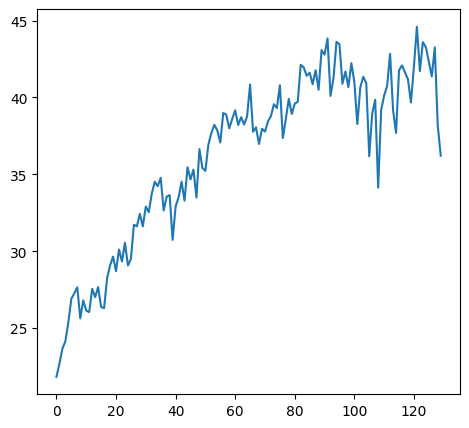

In [23]:
def main():
    disc = Discriminator(in_channels=3).to(Config.DEVICE)
    gen = Generator(in_channels=3, features=64).to(Config.DEVICE)
    
    # Initialisation des poids
    disc.apply(weights_init)
    gen.apply(weights_init)
    
    opt_disc = optim.Adam(disc.parameters(), lr=Config.LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gen.parameters(), lr=Config.LEARNING_RATE, betas=(0.5, 0.999))

    # Loss functions
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    # Dataset
    train_dataset = Pix2PixDataset(root_dir=Config.TRAIN_DIR)

    # Limitation de la taille du dataset si configure
    if Config.TRAIN_SIZE_LIMIT is not None and len(train_dataset) > Config.TRAIN_SIZE_LIMIT:
        print(f"Limitation du dataset train a {Config.TRAIN_SIZE_LIMIT} images (sur {len(train_dataset)} disponibles).")
        indices = torch.randperm(len(train_dataset))[:Config.TRAIN_SIZE_LIMIT]
        train_dataset = torch.utils.data.Subset(train_dataset, indices)

    # Pour éviter les erreurs si la dataset n'est pas liee, on verifie la taille
    if len(train_dataset) > 0:
        train_loader = DataLoader(
            train_dataset,
            batch_size=Config.BATCH_SIZE,
            shuffle=True,
            num_workers=Config.NUM_WORKERS,
            pin_memory=True, # Optimisation GPU
        )
        # Val loader (optional subset)
        val_dataset = Pix2PixDataset(root_dir=Config.VAL_DIR)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False) if len(val_dataset) > 0 else train_loader
        
        # Mixed Precision Scalers (Mise a jour pour torch.amp)
        g_scaler = torch.amp.GradScaler('cuda')
        d_scaler = torch.amp.GradScaler('cuda')
        
        history = {'train_g_loss': [], 'train_d_loss': [], 'val_g_loss': [], 'val_d_loss': []}
        best_val_g_loss = float('inf')
        patience_counter = 0

        for epoch in range(Config.NUM_EPOCHS):
            print(f"Epoch [{epoch}/{Config.NUM_EPOCHS}]")
            train_d_loss, train_g_loss = train_fn(
                disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler
            )
            
            history['train_g_loss'].append(train_g_loss)
            history['train_d_loss'].append(train_d_loss)
            print(f"Train Loss D: {train_d_loss:.4f}, G: {train_g_loss:.4f}")

            # --- VALIDATION TOUTES LES 10 EPOCHS ---
            # (On teste si (epoch + 1) est un multiple de 10 ou si c'est la dernière epoch)
            if (epoch + 1) % 10 == 0 or epoch == Config.NUM_EPOCHS - 1:
                print(f"--- Running Validation at Epoch {epoch} ---")
                val_d_loss, val_g_loss = validate_fn(disc, gen, val_loader, L1_LOSS, BCE)
                
                print(f"Val Loss D: {val_d_loss:.4f}, G: {val_g_loss:.4f}")
                
                history['val_g_loss'].append(val_g_loss)
                history['val_d_loss'].append(val_d_loss)

                save_some_examples(gen, val_loader, epoch, folder="evaluation")
                
                # Best Model & Early Stopping (uniquement lors de la validation)
                if val_g_loss < best_val_g_loss:
                    best_val_g_loss = val_g_loss
                    print(f"New best model found (Val G Loss: {best_val_g_loss:.4f}). Saving...")
                    torch.save(gen.state_dict(), Config.CHECKPOINT_GEN_BEST)
                    torch.save(disc.state_dict(), Config.CHECKPOINT_DISC)
                    patience_counter = 0
                else:
                    patience_counter += 1
                    print(f"No improvement. Patience: {patience_counter}/{Config.PATIENCE}")
                    
                if patience_counter >= Config.PATIENCE:
                    print("Early stopping triggered.")
                    break
                
        # Fin du training : Plot et Log
        plot_history(history)
        log_experiment(Config, {"val_g_loss": best_val_g_loss}, history, Config.LOG_FILE)

    else:
        print(f"Aucune image trouvee dans {Config.TRAIN_DIR}. Veuillez configurer/charger le dataset.")

if __name__ == "__main__":
    main()

# 8. Inference (Test final)

In [ ]:
def run_inference():
    print("--- Lancement de l'Inference (Validation Set) ---")
    gen = Generator(in_channels=3, features=64).to(Config.DEVICE)
    
    if os.path.exists(Config.CHECKPOINT_GEN_BEST):
        print(f"Chargement du modele depuis {Config.CHECKPOINT_GEN_BEST}")
        checkpoint = torch.load(Config.CHECKPOINT_GEN_BEST, map_location=Config.DEVICE)
        gen.load_state_dict(checkpoint)
    else:
        print("Aucun checkpoint trouve ! Assurez-vous d'avoir entraine le modele.")
        return

    # Setup val loader
    val_dataset = Pix2PixDataset(root_dir=Config.VAL_DIR)
    if len(val_dataset) == 0:
        print("Pas de dataset de validation.")
        return
        
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
    
    gen.eval()
    n_samples = 5
    
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))
    plt.tight_layout()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            if i >= n_samples: break
            
            x = x.to(Config.DEVICE)
            y_fake = gen(x).cpu()
            x = x.cpu()
            y = y # target (ground truth)
            
            # Denormalize
            x = x * 0.5 + 0.5
            y = y * 0.5 + 0.5
            y_fake = y_fake * 0.5 + 0.5
            
            # Plot
            # Input
            axes[i, 0].imshow(x.squeeze().permute(1, 2, 0))
            axes[i, 0].set_title("Input (Sketch/Facade)")
            axes[i, 0].axis("off")
            
            # Generated
            axes[i, 1].imshow(y_fake.squeeze().permute(1, 2, 0))
            axes[i, 1].set_title("Generated (Pix2Pix)")
            axes[i, 1].axis("off")

            # Target
            axes[i, 2].imshow(y.squeeze().permute(1, 2, 0))
            axes[i, 2].set_title("Target (Ground Truth)")
            axes[i, 2].axis("off")
            
    plt.show()

run_inference()


--- Lancement de l'Inference (Validation Set) ---
Chargement du modele depuis gen_best.pth.tar
